In [1]:
import pandas as pd


In [3]:
df.columns


Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [4]:
# ---- Target & Features ----

# IMPORTANT: adjust target name if needed
TARGET_COL = df.columns[-1]  # last column is usually the target

y = df[TARGET_COL]
X = df.drop(TARGET_COL, axis=1)

y.value_counts()


default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

y_train.mean(), y_test.mean()


(np.float64(0.2212), np.float64(0.2212))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [8]:
y_test_probs = model.predict_proba(X_test_scaled)[:, 1]
y_test_probs[:10]


array([0.73003918, 0.66101983, 0.59956191, 0.81283912, 0.39794204,
       0.40024877, 0.77133947, 0.31228586, 0.23442231, 0.51048847])

In [9]:
def selective_predict(probs, low=0.3, high=0.7):
    """
    Returns:
    0 -> confident negative
    1 -> confident positive
    -1 -> abstain
    """
    decisions = []
    for p in probs:
        if p <= low:
            decisions.append(0)
        elif p >= high:
            decisions.append(1)
        else:
            decisions.append(-1)
    return np.array(decisions)


In [11]:
import numpy as np


In [12]:
y_sel = selective_predict(y_test_probs, low=0.3, high=0.7)
y_sel[:20]


array([ 1, -1, -1,  1, -1, -1,  1, -1,  0, -1, -1, -1, -1,  0, -1, -1,  0,
        1, -1,  1])

In [13]:
coverage = np.mean(y_sel != -1)
coverage


np.float64(0.3121333333333333)

In [14]:
mask = y_sel != -1
selective_accuracy = np.mean(y_sel[mask] == y_test.values[mask])
selective_accuracy


np.float64(0.7894062366510038)

In [15]:
coverages = []
risks = []

thresholds = np.linspace(0.1, 0.5, 20)

for t in thresholds:
    y_sel = selective_predict(y_test_probs, low=t, high=1 - t)
    
    mask = y_sel != -1
    coverage = np.mean(mask)
    
    if coverage > 0:
        risk = 1 - np.mean(y_sel[mask] == y_test.values[mask])
    else:
        risk = 0
    
    coverages.append(coverage)
    risks.append(risk)


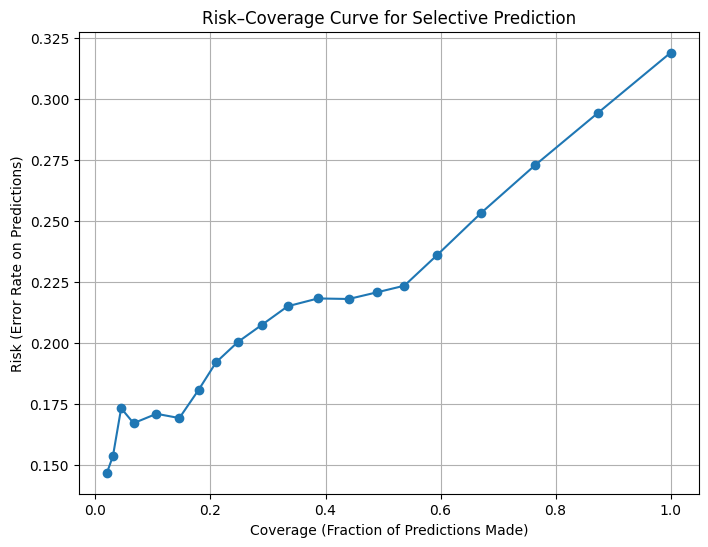

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(coverages, risks, marker='o')
plt.xlabel("Coverage (Fraction of Predictions Made)")
plt.ylabel("Risk (Error Rate on Predictions)")
plt.title("Risk–Coverage Curve for Selective Prediction")
plt.grid(True)
plt.show()


In [17]:
# ---- Cost assumptions ----
COST_WRONG = 100      # wrong automatic decision
COST_ABSTAIN = 10     # human review / delay


In [18]:
def total_cost_selective(y_true, y_sel):
    cost = 0
    for yt, yp in zip(y_true, y_sel):
        if yp == -1:
            cost += COST_ABSTAIN
        elif yp != yt:
            cost += COST_WRONG
    return cost


In [19]:
policy_costs = []

for t in thresholds:
    y_sel = selective_predict(y_test_probs, low=t, high=1 - t)
    cost = total_cost_selective(y_test.values, y_sel)
    policy_costs.append(cost)

best_t = thresholds[np.argmin(policy_costs)]
best_t


np.float64(0.1)

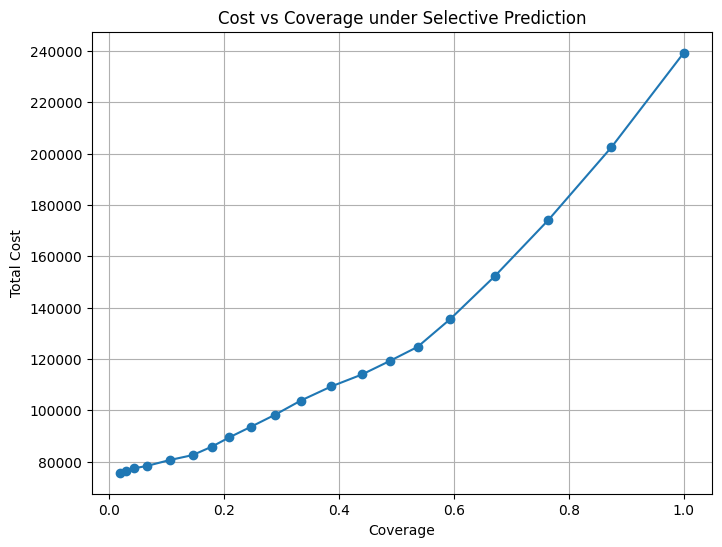

In [20]:
plt.figure(figsize=(8,6))
plt.plot(coverages, policy_costs, marker='o')
plt.xlabel("Coverage")
plt.ylabel("Total Cost")
plt.title("Cost vs Coverage under Selective Prediction")
plt.grid(True)
plt.show()
